# <u> 3.1 Pre-processing and Transformation </u>

In [1]:
"""
AUTHOR: F015011
DATE: April / May 2023

The following notebook contains code used to answer assessment task 3.1 "Pre-processing and Transformation".

"""
# import required packages
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Pre-processing Functions

Preprocessing functions are an essential part of data mining and machine learning workflows; they will help us transform and prepare our datasets to make them suitable for modeling. In this case, they have each been written independently to ensure reusability.

## Check for Missing Data

In [2]:
def get_missing_data(data, plot=True):
    """
    Calculate the number of missing values in each column of the given data. DIsplay as a table.

    Parameters:
        data (numpy.ndarray): The input data as a numpy ndarray.
        plot (bool, optional): Whether to plot the missing values table. Defaults to True.

    Returns:
        numpy.ndarray: An array containing the number of missing values in each column.

    """
    num_rows, num_cols = data.shape
    missing_values = np.zeros(num_cols, dtype=int)

    # Count the number of missing values in each column
    for col in range(num_cols):
        missing_values[col] = np.sum(data[:, col] == '', axis=0)    

    if plot:
        # Display the missing value statistics in a Markdown table
        display(Markdown('| Column Index | Missing Values |\n'
                        '| --- | --- |\n' + 
                        ''.join(f'| {i} | {val} |\n' for i, val in enumerate(missing_values))))

    return missing_values


## Identify Numeric and Non-numeric Columns

In [3]:
def get_non_numeric_columns(data):
    """
    Identify the non-numeric columns in a numpy ndarray.

    Parameters:
        arr (numpy.ndarray): The input data as a numpy ndarray.

    Returns:
         numpy.ndarray: A list of column indices with associated non-numeric values.

    """
    non_numeric_cols = []

    # Iterate over each column
    for col_i in range(len(data[0])):
        numeric = True

        # Check each cell in the column
        for row_i in range(len(data)):
            cell = data[row_i][col_i]

            if cell != "":
                # Check if the cell contains non-numeric characters
                if not all(c.isdigit() or c in ('.', '-') for c in cell):
                    numeric = False
                    break

        if not numeric:
            # If column contains non-numeric values, add its index to the list
            non_numeric_cols.append(col_i)

    return non_numeric_cols


def get_numeric_columns(data):
    """
    Identify the numeric columns in a numpy ndarray.

    Parameters:
        arr (numpy.ndarray): The input data as a numpy ndarray.

    Returns:
        numpy.ndarray: A list of column indices with associated numeric values.

    """
    numeric_cols = []

    # Iterate over each column
    for col_i in range(len(data[0])):
        numeric = True

        # Check each cell in the column
        for row_i in range(len(data)):
            cell = data[row_i][col_i]

            if cell != "":
                # Check if the cell contains non-numeric characters
                if not all(c.isdigit() or c in ('.', '-') for c in cell):
                    numeric = False
                    break

        if numeric:
            # If column contains numeric values, add its index to the list
            numeric_cols.append(col_i)

    return numeric_cols


## Data Imputation

In [4]:
def impute_data(data):
    """
    Impute missing values in a numpy ndarray using the K-Nearest Neighbors (KNN) algorithm.

    Parameters:
        data (numpy.ndarray): The input numpy ndarray.

    Returns:
        numpy.ndarray: The numpy array with imputed missing values.

    """
    # Convert empty strings to NaN
    data = np.where(data == '', np.nan, data)

    # Create a KNNImputer object
    KNN_imputer = KNNImputer()

    # Impute missing values in the data
    imputed_data = KNN_imputer.fit_transform(data)

    return imputed_data

## Data Encoding (Ordinal)
Each categorical (non-numerical) value is assigned a unique integer value based on the order it is in. This will preserve the order between non-numeric data points when endoding. 

In [5]:
def ordinal_encode(data):
    """
    Perform ordinal encoding on categorical columns in a numpy ndarray.

    Parameters:
        data (numpy.ndarray): The input numpy ndarray.

    Returns:
        numpy.ndarray: The array with ordinal-encodd categorical columns.

    """
    # Get the categorical columns (they will be non-numeric in this case)
    categorical_columns = get_non_numeric_columns(data)

    # Create the ordinal encoder
    ordinal_encoder = OrdinalEncoder()

    # Copy the input data to avoid modifying the original array
    encoded_data = data.copy()

    # Iterate over each categorical column and perform ordinal encoding
    for column_idx in categorical_columns:
        column = data[:, column_idx]
        column = column.reshape(-1, 1)  # Need to reshape to fit the encoder
        encoded_column = ordinal_encoder.fit_transform(column)
        encoded_data[:, column_idx] = encoded_column.ravel()

    return encoded_data


## Data Normalisation
The features are normalised within a range between 0 and 1 using minmax scaling. This prevents certain features with larger scales skewing the learning process. Minmax scaling is useful as it preserves the original distributions of the dataset features. 

In [6]:
def rescale_data(data):
    """
    Rescale the selected columns in a numpy ndarray to a specified range.

    Parameters:
        data (numpy.ndarray): The input numpy ndarray.

    Returns:
        numpy.ndarray: The array with rescaled selected columns.

    """
    # Get all columns except the last one
    cols_to_scale = slice(None, -1)

    # Create an instance of the scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Copy the input data to avoid modifying the original array
    normalised_data = data.copy()

    # Fit and transform the selected columns using the scaler
    normalised_data[:, cols_to_scale] = scaler.fit_transform(data[:, cols_to_scale])

    return normalised_data

## Feature Selection
For regression, the pearson correlation is used to select the target features as it models the linear relationships amoung features. This is not suitable for more complex relationships required by classifcation sets and so chi2 is used for our classification sets. This option can be specified when calling the feature selections function. 

In [7]:
def select_features(data, plot=True, k=5, corr_method='pearson'):
    """
    Select the top k features from the input data based on correlation with the target variable.

    Parameters:
        data (numpy.ndarray): The input numpy ndarray with features and target variable.
        plot (bool, optional): Whether to plot feature correlations. Defaults to True.
        k (int, optional): The number of top features to select. Defaults to 5.
        corr_method (str, optional): The method to measure feature-target correlation.
            Valid options are 'chi2' (chi-squared test) or 'pearson' (Pearson correlation coefficient).
            Defaults to 'pearson'.

    Returns:
        numpy.ndarray: The numpy ndarray with selected features.

    Raises:
        ValueError: If an invalid corr_method is specified.

    """
    # Split the data into features and target variable
    X = data[:, :-1]
    y = data[:, -1]

    if corr_method == 'chi2':
        # Use SelectKBest to select the top k features based on chi-squared test
        selector = SelectKBest(score_func=chi2, k=k)
    elif corr_method == 'pearson':
        # Use SelectKBest to select the top k features based on Pearson correlation coefficient
        selector = SelectKBest(score_func=f_regression, k=k)
    else:
        raise ValueError("Invalid method specified. Please choose 'chi2' or 'pearson'.")

    # Perform feature selection
    X_new = selector.fit_transform(X, y)

    # Get the indices of the top k features
    top_features = selector.get_support(indices=True)

    # Append target variable index to the selected features
    top_features = np.append(top_features, [X.shape[1]])

    # Create a new array with the selected features
    selected_data = data[:, top_features]

    # Plot feature correlations if plot=True
    if plot:
        plot_feature_correlations(selected_data, corr_method)

    return selected_data

### Feature Selection Plotting
A confusion matrix and bar chart are both used to illustrate the relative correlations identified by our correlation coefficients. Confusion matrices are useful for breaking down the correlations amoung all the selected features. 

In [8]:
def plot_feature_correlations(data, corr_method, feature_labels=None):
    """
    Plots the correlation matrix and feature correlations with the target variable.

    Parameters:
        data (numpy.ndarray): The data array with selected features and target variable.
        corr_method (str): The correlation method used.
        feature_labels (list, optional): The labels or names of the features. Default is None.

    Returns:
        None
    """
    # Compute the correlation matrix between selected features and the target variable
    corr_matrix = np.corrcoef(data.T)

    # Get the absolute correlation values with respect to the target variable
    corr_with_target = np.abs(corr_matrix[:-1, -1])

    # Sort features based on their correlation with the target variable
    sorted_features_indices = np.argsort(corr_with_target)[::-1]

    # Plot creation for feature correlations
    fig, (heatmap_ax, barplot_ax) = plt.subplots(ncols=2, figsize=(10, 5))

    # Heatmap
    sns.heatmap(data=corr_matrix, cmap='coolwarm', ax=heatmap_ax)
    heatmap_ax.set_title(f'Correlation Matrix ({corr_method} correlation)')

    # Bar plot
    if feature_labels is not None:
        barplot_ax.barh(range(len(sorted_features_indices)), corr_with_target[sorted_features_indices])
        barplot_ax.set_yticks(range(len(sorted_features_indices)))
        barplot_ax.set_yticklabels(feature_labels[sorted_features_indices])
    else:
        barplot_ax.barh(range(len(sorted_features_indices)), corr_with_target[sorted_features_indices])
        barplot_ax.set_yticks(range(len(sorted_features_indices)))
        barplot_ax.set_yticklabels(sorted_features_indices)
    barplot_ax.set_xlabel('Absolute Correlation Coefficient')
    barplot_ax.set_ylabel('Feature')
    barplot_ax.set_title(f'Top Features by Correlation with Target ({corr_method} correlation)')

    # Adjust spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()


## Dataset Visualisation
Principal Component Analysis (PCA) is very useful for visualising a given dataset's structure as it reduces the dimensions while preserving the princvipal components, i.e., those that are most significant in terms of the information they represent regarding the dataset. As a result, we use PCA to illustrate the dataset throughout the stages of pre-processing on a single 2D scatter plot. 

In [9]:
def plot_dataset(data):
    """
    Visualise the dataset using a scatter plot after applying PCA for dimensionality reduction.

    Parameters:
        data (numpy.ndarray): The input numpy ndarray representing the dataset.

    Returns:
        None

    """
    # Get the number of features in the dataset
    num_features = data.shape[1]

    # Apply PCA to reduce dimensionality to 2 components
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Create scatter plot of the reduced data
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Dataset Visualisation')
    plt.show()

## Preprocessing Pipeline

In [10]:
def preprocess_data(data, plot=True, feature_method='pearson'):
    """
    Preprocesses the input data by performing various steps such as: encoding non-numerical values,
    handling missing values, rescaling the data, and selecting features.

    Parameters:
        data (numpy.ndarray): The input numpy ndarray representing the dataset (assumed to have been read using np.gentext).
        plot (bool, optional): Whether to plot intermediate results. Defaults to True.
        feature_method (str, optional): The method to use for feature selection.
            Valid options are 'chi2' (chi-squared test) or 'pearson' (Pearson correlation coefficient).
            Defaults to 'pearson'.

    Returns:
        numpy.ndarray: The preprocessed data with selected features.

    """
    if plot:
        display(Markdown("### Initial Dataset"))
        display(data)
        display(Markdown("### Encode Non-numerical Values"))
    data = ordinal_encode(data)
    if plot:
        display(data)
        display(Markdown("### Missing Values"))
    missing_values = get_missing_data(data, plot)
    if plot:
        display(Markdown("### Impute Missing Values"))
    data = impute_data(data)
    if plot:
        plot_dataset(data)
        display(Markdown("### Missing Values After Imputation"))
    missing_values = get_missing_data(data, plot)
    if plot:
        display(Markdown("### Rescale (Normalise) Data"))
    rescaled_data = rescale_data(data)
    if plot:
        plot_dataset(rescaled_data)
        display(Markdown("### Select Features"))
    selected_features = select_features(rescaled_data, plot, 5, feature_method)
    if plot:
        plot_dataset(selected_features)
    return selected_features


# Pre-processing Tasks
To preprocess a given dataset, we can start by reading the data from a CSV file using the `np.genfromtxt` function. Assuming that the last column of the dataset is the target column, we can then call the `preprocess_data` function to perform the necessary preprocessing steps.

## Preprocessing Steps
1. Identify missing values
2. Encode non-numerical data values using ordinal encoding
3. Impute missig data values
4. Rescale (normalise) data
5. Select features correlated above threshhold value

# Garments Regression Pre-processing

The Garment Worker Productivity Dataset is a real-world dataset that contains various features related to the productivity of garment workers. By applying preprocessing techniques, we aim to create a clean and structured dataset that can be used for accurate regression modeling and analysis. 

### Initial Dataset

array([['1/1/2015', 'Quarter1', 'sweing', ..., '0', '59', '0.940725424'],
       ['1/1/2015', 'Quarter1', 'finishing ', ..., '0', '8', '0.8865'],
       ['1/1/2015', 'Quarter1', 'sweing', ..., '0', '30.5',
        '0.800570492'],
       ...,
       ['3/11/2015', 'Quarter2', '', ..., '0', '8', '0.625625'],
       ['3/11/2015', 'Quarter2', 'finishing', ..., '0', '15',
        '0.505888889'],
       ['3/11/2015', 'Quarter2', 'finishing', ..., '0', '6',
        '0.394722222']], dtype='<U11')

### Encode Non-numerical Values

array([['1.0', '1.0', '3.0', ..., '0', '59', '0.940725424'],
       ['1.0', '1.0', '2.0', ..., '0', '8', '0.8865'],
       ['1.0', '1.0', '3.0', ..., '0', '30.5', '0.800570492'],
       ...,
       ['52.0', '2.0', '0.0', ..., '0', '8', '0.625625'],
       ['52.0', '2.0', '1.0', ..., '0', '15', '0.505888889'],
       ['52.0', '2.0', '1.0', ..., '0', '6', '0.394722222']], dtype='<U11')

### Missing Values

| Column Index | Missing Values |
| --- | --- |
| 0 | 0 |
| 1 | 0 |
| 2 | 0 |
| 3 | 0 |
| 4 | 12 |
| 5 | 17 |
| 6 | 8 |
| 7 | 506 |
| 8 | 9 |
| 9 | 5 |
| 10 | 12 |
| 11 | 12 |
| 12 | 13 |
| 13 | 10 |
| 14 | 0 |


### Impute Missing Values

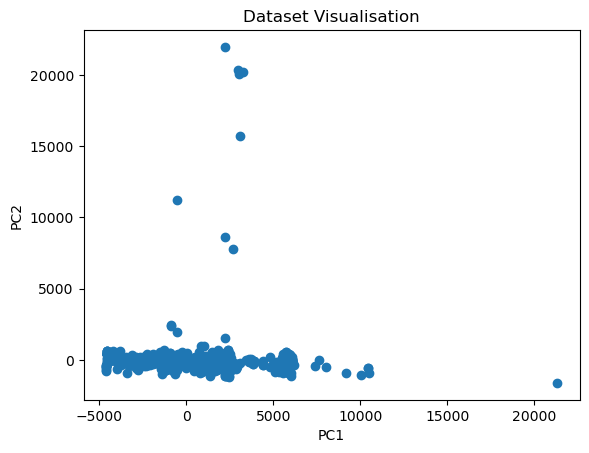

### Missing Values After Imputation

| Column Index | Missing Values |
| --- | --- |
| 0 | 0 |
| 1 | 0 |
| 2 | 0 |
| 3 | 0 |
| 4 | 0 |
| 5 | 0 |
| 6 | 0 |
| 7 | 0 |
| 8 | 0 |
| 9 | 0 |
| 10 | 0 |
| 11 | 0 |
| 12 | 0 |
| 13 | 0 |
| 14 | 0 |


### Rescale (Normalise) Data

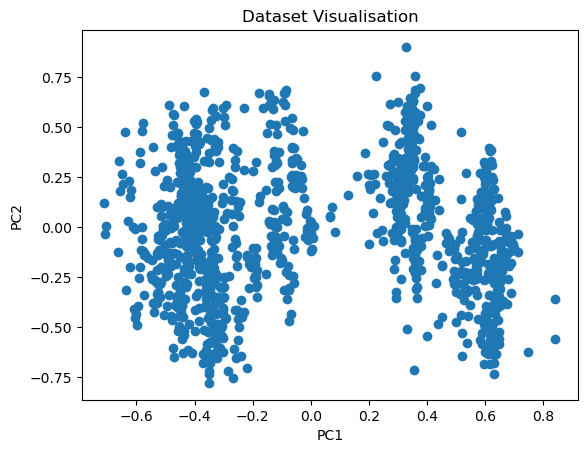

### Select Features

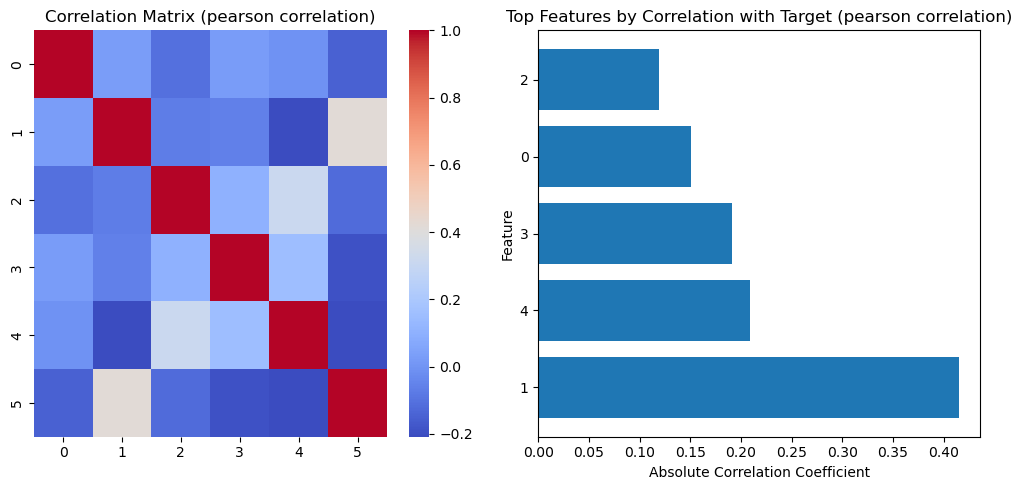

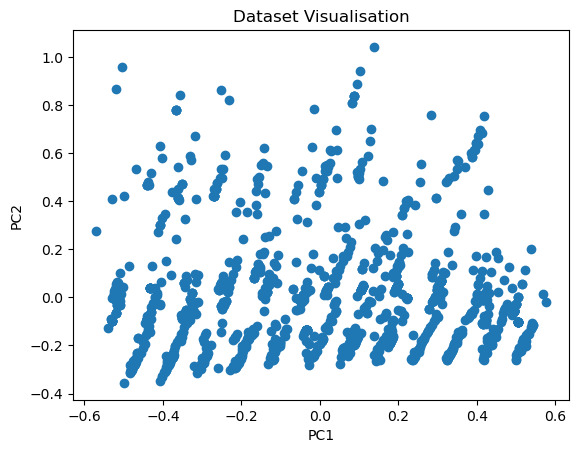

In [11]:
# Read garments_regression.csv file
garments_regression = np.genfromtxt('gwp_assessment.csv', delimiter=',', dtype=str, skip_header=True, filling_values='')
# Pre-process garments_regression data
garments_processed = preprocess_data(garments_regression, True, 'pearson')

# Star Classification Pre-processing

The Stellar Classification Dataset - SDSS17 is a real-world dataset that contains information about stars observed by the Sloan Digital Sky Survey (SDSS). This dataset includes various features such as the spectral properties and photometric measurements of stars. By applying  preprocessing techniques, we aim to create a clean and structured dataset that can be used for accurate classification modeling and analysis.

### Initial Dataset

array([['1237660961327743232', '135.6891066036', '32.4946318397087', ...,
        '56354', '171', 'GALAXY'],
       ['1237664879951151360', '144.826100550256', '31.2741848944939',
        ..., '58158', '427', 'GALAXY'],
       ['1237660961330430208', '142.188789562506', '35.5824441819976',
        ..., '55592', '299', 'GALAXY'],
       ...,
       ['1237668298220634368', '224.587407436133', '15.7007073929529',
        ..., '54535', '74', 'GALAXY'],
       ['1237661151383454208', '212.268621115206', '46.6603652793367',
        ..., '56368', '470', 'GALAXY'],
       ['1237661151378801152', '196.896052965211', '49.4646427730825',
        ..., '57104', '851', 'GALAXY']], dtype='<U20')

### Encode Non-numerical Values

array([['25155.0', '135.6891066036', '32.4946318397087', ..., '56354',
        '171', '0.0'],
       ['46400.0', '144.826100550256', '31.2741848944939', ..., '58158',
        '427', '0.0'],
       ['25183.0', '142.188789562506', '35.5824441819976', ..., '55592',
        '299', '0.0'],
       ...,
       ['58562.0', '224.587407436133', '15.7007073929529', ..., '54535',
        '74', '0.0'],
       ['26841.0', '212.268621115206', '46.6603652793367', ..., '56368',
        '470', '0.0'],
       ['26836.0', '196.896052965211', '49.4646427730825', ..., '57104',
        '851', '0.0']], dtype='<U20')

### Missing Values

| Column Index | Missing Values |
| --- | --- |
| 0 | 0 |
| 1 | 55 |
| 2 | 65 |
| 3 | 70 |
| 4 | 63 |
| 5 | 50 |
| 6 | 59 |
| 7 | 61 |
| 8 | 59 |
| 9 | 51 |
| 10 | 68 |
| 11 | 59 |
| 12 | 0 |
| 13 | 0 |
| 14 | 50 |
| 15 | 61 |
| 16 | 62 |
| 17 | 0 |


### Impute Missing Values

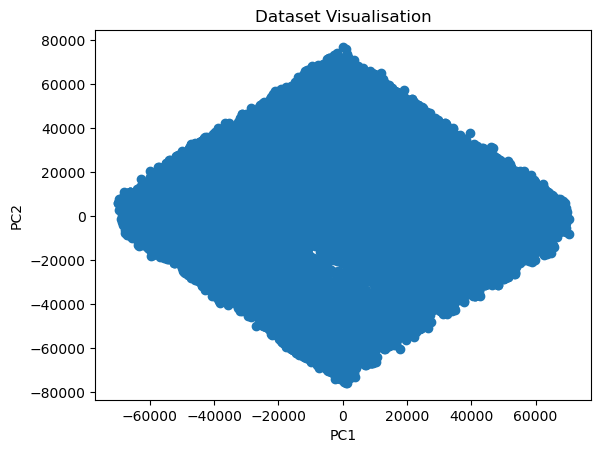

### Missing Values After Imputation

| Column Index | Missing Values |
| --- | --- |
| 0 | 0 |
| 1 | 0 |
| 2 | 0 |
| 3 | 0 |
| 4 | 0 |
| 5 | 0 |
| 6 | 0 |
| 7 | 0 |
| 8 | 0 |
| 9 | 0 |
| 10 | 0 |
| 11 | 0 |
| 12 | 0 |
| 13 | 0 |
| 14 | 0 |
| 15 | 0 |
| 16 | 0 |
| 17 | 0 |


### Rescale (Normalise) Data

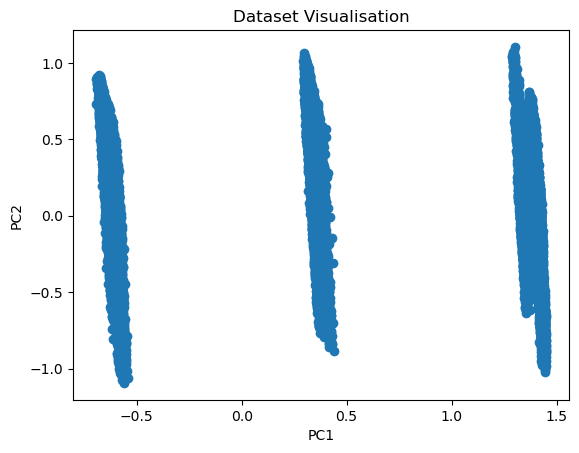

### Select Features

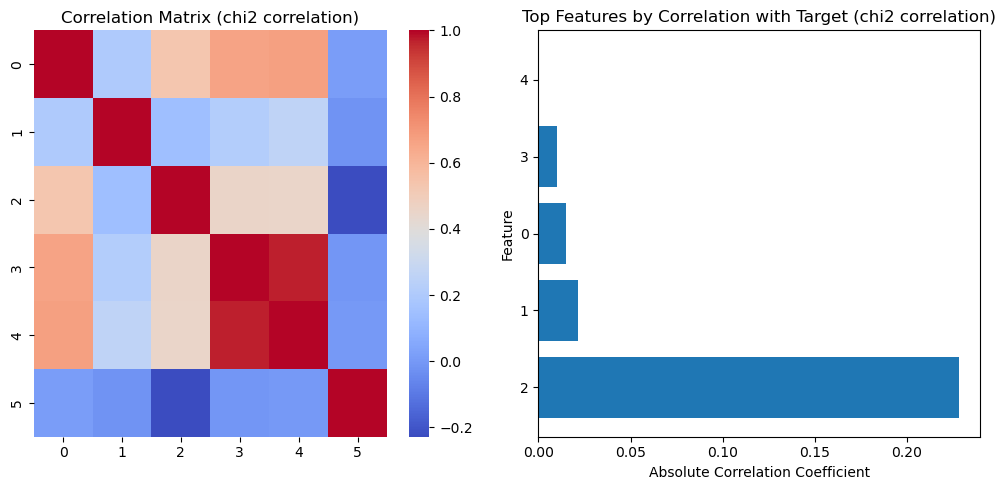

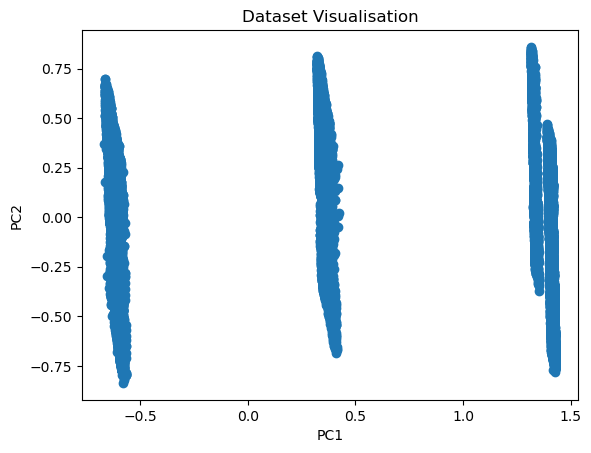

In [12]:
# Read star_classification.csv file
star_classification = np.genfromtxt('star_assessment.csv', delimiter=',', dtype=str, skip_header=True)
# Pre-process star_classification data
star_processed = preprocess_data(star_classification, True, 'chi2')

# Final Target Feature Distributions

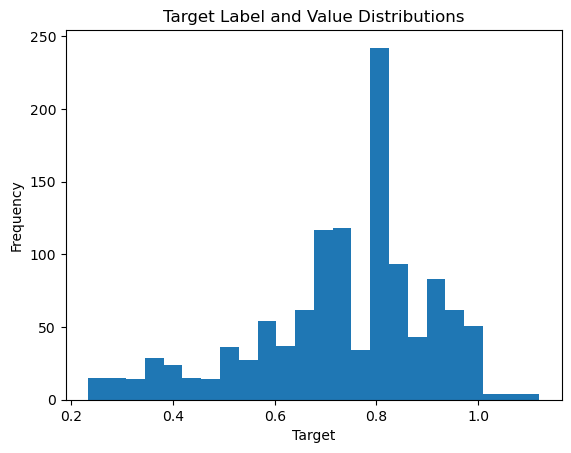

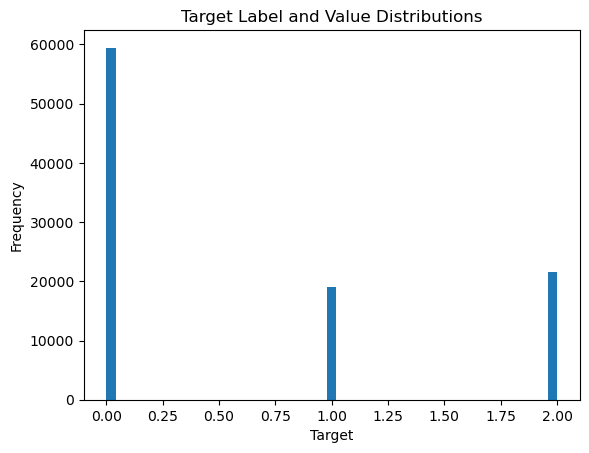

In [13]:
def visualise_target_features(data):
    """
    Visualises the target feature distribution for the processed dataset. 
    For classifier sets, labels must be encoded.

    Parameters:
        data (numpy.ndarray): The input dataset, assuming the target feature is the last column.

    Returns:
        None
    """
    # Extract the target feature from the dataset
    target = data[:, -1]

    # Plot a histogram of the target feature
    plt.hist(target, bins='auto')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.title('Target Label and Value Distributions')
    plt.show()
    
visualise_target_features(garments_processed)
visualise_target_features(star_processed)

# Markdown Question 1

**Explain the logic behind usage of pearson correlation coefficient for feature selection.**

The Pearson correlation coefficient measures the linear relationship between two variables; it is regularly used when quantifying the influence one variable has on another. The values of this coefficient range between -1 and +1, where negative and positive values indicate negative and positive correlations, receptively. Accordingly, a value of 0 demonstrates no linear correlation between the variables. Within the process of feature selection, we can use the Pearson correlation to measure the correlation between each feature within the dataset and our target variable, allowing us to identify the optimal features to be used as predictors when training our machine learning models. This can allow us to use the filter method to remove unnecessary features, reducing computational throughput when training our models as opposed to the use of manual, wrapper, or embedded methods. That being said, an import consideration of the Pearson coefficient is its limited ability to model relationships beyond a linear correlation. As a result, another coefficient may be required to accurately capture the complexities of a more complex, nonlinear relationship. 